![rome](rome.png)

# City of Rome Weather Analysis & Prediction
In this workbook I will analyze how Rome climate changed across the last four decades. Particularly, I will focus about temperature related aspects: annual average temperature and number of fog days. At the end, we will see how Rome climate could change in the near future.

Unfortunately, rain precipitation data are not reliable, so I will not use them in the analysis.

## 1. Configuration, Data Mining & Data Cleaning
In this section we will collect and clean data.

### Config
Set variables for city, start year / month and end year / month.

In [1]:
city = 'Roma'

start_year = 1980
start_month = 1

end_year = 2020
end_month = 12

### Config #2
Import libraries and data structures.

In [2]:
# Import libraries
import requests, csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn parameters
sns.set(rc = {'figure.figsize': (8, 4)}, font = 'calibri')
sns.set_context('notebook')
sns.set_style('whitegrid', {'grid.linestyle': ':', 'axes.spines.right': False, 'axes.spines.top': False})

# Import data structures
month_list = ['Gennaio', 'Febbraio', 'Marzo', 'Aprile', 'Maggio', 'Giugno', 'Luglio', 'Agosto', 'Settembre', 'Ottobre', 'Novembre', 'Dicembre']

header = ['city', 'date', 't_avg_c', 't_min_c', 't_max_c', 'dew_point_c', 'humidity_%', 'visibility_km', 'wind_avg_kmh', 'wind_max_kmh', 'gust_kmh', 'air_pressure_asl_mb', 'air_pressure_avg_mb', 'rain_mm', 'phenomena']

convert_dict = {'t_avg_c': float, 't_min_c': float, 't_max_c': float, 'dew_point_c': float, 'humidity_%': int, 'visibility_km': int, 'wind_avg_kmh': int, 'wind_max_kmh': int, 'gust_kmh': int, 'air_pressure_asl_mb': int, 'air_pressure_avg_mb': int, 'rain_mm': float}

### Data Scraping
Download weather data from www.ilmeteo.it and store them into **weather_list** list (it takes a while).

In [3]:
weather_list = []

for year in range(start_year, end_year + 1):
    
    for month in range(start_month - 1, end_month):
        
        CSV_URL = 'https://www.ilmeteo.it/portale/archivio-meteo/' + city + '/' + str(year) + '/' + month_list[month] + '?format=csv'

        with requests.Session() as s:
            download = s.get(CSV_URL)  # Set the connection

            decoded_content = download.content.decode('utf-8')  # Decode csv content

            records = csv.reader(decoded_content.splitlines(), delimiter = ';')  # Read csv content
            weather_list += list(records)[1::]  # Convert "csv.reader" object in list and glue it into "weather_list" with no header

,city,date,t_avg_c,t_min_c,t_max_c,dew_point_c,humidity_%,visibility_km,wind_avg_kmh,wind_max_kmh,gust_kmh,air_pressure_asl_mb,air_pressure_avg_mb,rain_mm,phenomena
0,Roma,1/1/1980,"4,8",-1,10,"-0,1",70,11,10,42,0,0,0,0,pioggia
1,Roma,2/1/1980,"4,3",2,6,"1,3",81,9,18,46,52,0,0,0,pioggia
2,Roma,3/1/1980,"1,7",-2,5,"-5,6",58,11,18,33,59,0,0,0,
3,Roma,4/1/1980,"-0,9",-5,5,"-6,2",67,8,1,11,0,0,0,0,
4,Roma,5/1/1980,"3,4",-3,9,"0,2",79,7,11,33,52,0,0,0,pioggia temporale


(14976, 15)


### Data Cleaning
Glue weather data into **weather_df** DataFrame and clean them.

In [4]:
weather_df = pd.DataFrame(weather_list, columns = header)

# Replace empty cells with NaN, NaN phenomena with zeros, commas with dots
weather_df = weather_df.replace(r'^\s*$', np.nan, regex = True)
weather_df['phenomena'] = weather_df['phenomena'].fillna('none')
weather_df = weather_df.replace(',', '.', regex = True)

# Drop NaN
weather_df.dropna(inplace = True)

# Convert with correct data types
weather_df['date'] = pd.to_datetime(weather_df['date'], dayfirst = True)
weather_df = weather_df.astype(convert_dict)


display(weather_df.head())

,city,date,t_avg_c,t_min_c,t_max_c,dew_point_c,humidity_%,visibility_km,wind_avg_kmh,wind_max_kmh,gust_kmh,air_pressure_asl_mb,air_pressure_avg_mb,rain_mm,phenomena
0,Roma,1980-01-01,4.8,-1.0,10.0,-0.1,70,11,10,42,0,0,0,0.0,pioggia
1,Roma,1980-01-02,4.3,2.0,6.0,1.3,81,9,18,46,52,0,0,0.0,pioggia
2,Roma,1980-01-03,1.7,-2.0,5.0,-5.6,58,11,18,33,59,0,0,0.0,none
3,Roma,1980-01-04,-0.9,-5.0,5.0,-6.2,67,8,1,11,0,0,0,0.0,none
4,Roma,1980-01-05,3.4,-3.0,9.0,0.2,79,7,11,33,52,0,0,0.0,pioggia temporale


### Data Cleaning #2
Clean data on *'phenomena'* column.

In [5]:
weather_df.loc[weather_df['phenomena'].str.contains('temporale|grandine'), 'phenomena'] = 'storm'
weather_df.loc[weather_df['phenomena'].str.contains('pioggia'), 'phenomena'] = 'rain'
weather_df.loc[weather_df['phenomena'].str.contains('neve'), 'phenomena'] = 'snow'
weather_df.loc[weather_df['phenomena'].str.contains('nebbia'), 'phenomena'] = 'fog'

print(weather_df['phenomena'].unique())

['rain' 'none' 'storm' 'fog' 'snow']


## 2. Exploratory Analysis
In this section we will analyze correlation between variables.

### Analysis
Group weather data by year.

In [6]:
# Find annual average temperature
analysis = weather_df.groupby(weather_df['date'].dt.year)[['t_avg_c', 't_min_c', 't_max_c', 'humidity_%', 'visibility_km']].mean().reset_index()

# Find annual fog days
analysis_2 = weather_df[weather_df['phenomena'] == 'fog'].groupby(weather_df['date'].dt.year)['phenomena'].count().reset_index()

# Merge temperature and fog data
analysis_merge = pd.merge(analysis, analysis_2, on = 'date')

Plot correlation between variables.

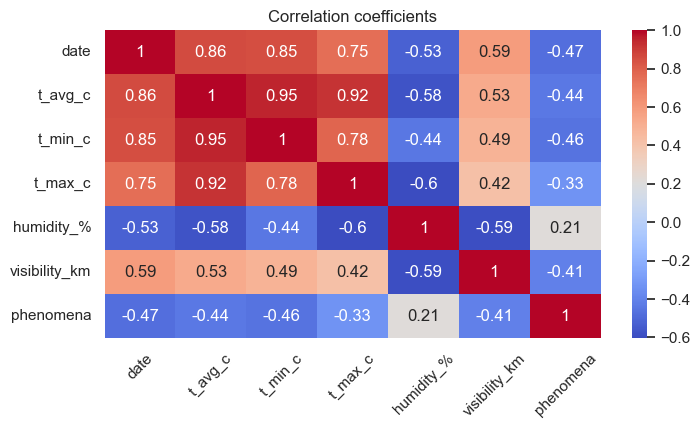

In [7]:
# Set palette color
p = sns.color_palette('coolwarm', as_cmap = True)

# Plot correlation coefficients
sns.heatmap(analysis_merge.corr(), cmap = p, annot = True)
plt.xticks(rotation = 45)
plt.title('Correlation coefficients')

plt.show()

Correlation coefficient between date and average temperature is very strong (0.86). Also, there's a relevant negative correlation between date and fog days (-0.47 - *fog days* is indicated by column "phenomena"). We can hypotesize that an increase in temperature has caused a decrease in fog days.

### Data Visualization
We can visualize how temperature has increased and fog days decreased over time.

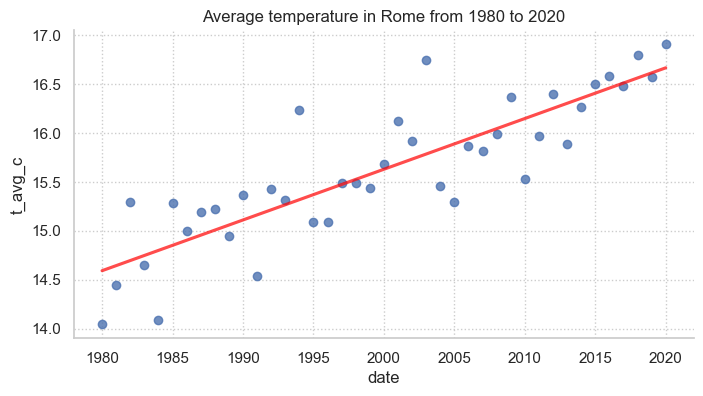

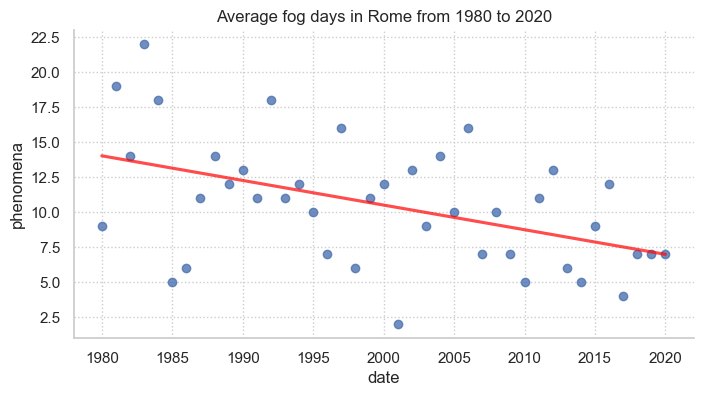

In [18]:
# Plot average temperature by year
sns.regplot(x = 'date', y = 't_avg_c', data = analysis_merge, ci = False, line_kws = {'color': 'red', 'alpha': 0.7}).set(title = 'Average temperature in Rome from 1980 to 2020')
plt.show()

# Plot fog days by year
sns.regplot(x = 'date', y = 'phenomena', data = analysis_merge, ci = False, line_kws = {'color': 'red', 'alpha': 0.7}).set(title = 'Average fog days in Rome from 1980 to 2020')
plt.show()

## 3. Modelling
In this section we will predict future Rome temperature.

### Config
Import libraries.

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

### Data Modelling

Set X and y variables.

In [10]:
# Assign date to X and average temperature to y
X = analysis_merge['date'].values.reshape(-1, 1)
y = analysis_merge['t_avg_c'].values.reshape(-1, 1)

To choose the best performing model, we will perform cross validation and compare their median accuracy.

Linear Regression accuracy is: 0.71531
Lasso accuracy is: 0.69545
Rigde accuracy is: 0.71527
Random Forest Regressor accuracy is: 0.49509
Support Vector Regression accuracy is: 0.6015


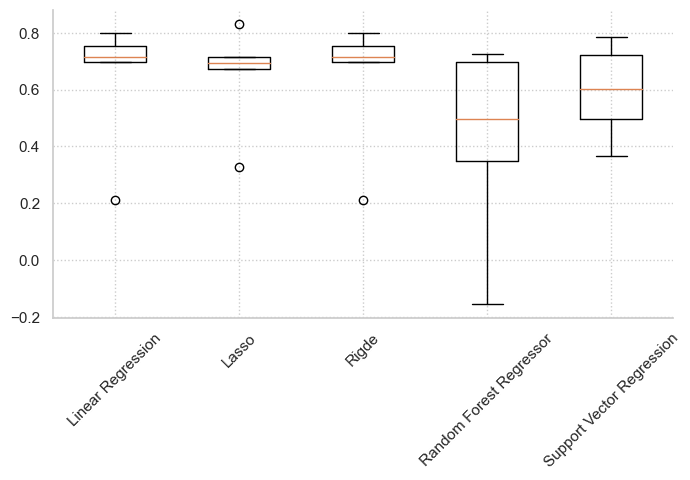

In [11]:
# Inizialize models
models = {'Linear Regression': LinearRegression(),
          'Lasso': Lasso(),
          'Rigde': Ridge(),
          'Random Forest Regressor': RandomForestRegressor(),
          'Support Vector Regression': SVR()}

# Append models median accuracy into "results" list
results = []

for model_name, model in models.items():
    cv = KFold(n_splits = 5, random_state = 0, shuffle = True)   
    cv_scores = cross_val_score(model, X, y, cv = cv)    
    results.append(cv_scores)
    print('{} accuracy is: {}'.format(model_name, round(np.median(cv_scores), 5)))

plt.boxplot(results, labels = models.keys())
plt.xticks(rotation = 45)
plt.show()

Linear Regression performs slightly better, so we can use this model to predict temperature.

In [12]:
# Inizialize model and calculate mean absolute error
linreg = LinearRegression()

cv = KFold(n_splits = 5, random_state = 0, shuffle = True)
mae = cross_val_score(linreg, X, y, cv = cv, scoring = 'neg_mean_absolute_error')
mae = abs(round(np.mean(mae), 3))

# Fit the model and predict Rome temperature
linreg.fit(X, y)

X_2050 = np.array([2050]).reshape(1, 1)
y_pred = linreg.predict(X_2050).round(2)

print('Rome average temperature in year {} will be: {} +- {}°C.'.format(X_2050, y_pred, mae))

Rome average temperature in year [[2050]] will be: [[18.22]] +- 0.297°C.


## 4. Conclusion
The model predicts that Rome average temperature in year 2050 will be **18.22°C** with a mean absolute error of 0.3°C. This means that there are good chances that Rome future average temperature will stand between 17.92°C and 18.52°C.

To better understand what this data means:
- Rome average temperature in 2020 was 16.9°C (from 1 to 1.6 degrees lower).
- Marrakesh average temperature in the past decade was 18.7°C.